In [1]:
import math
import random
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

from pcpptc import utils
from pcpptc.grid_solver import PointVertex
from pcpptc.grid_solver.cycle_connecting import connect_cycles_via_pcst
from pcpptc.instance_converter.polygonal_area import PolygonalArea
from pcpptc.plot.intermediate import plot_environment, plot_points, plot_graph
from pcpptc.polygon_instance.statistics import InstanceStatistics
from pcpptc.plot import setup_plot, plot_polygon_instance
from pcpptc.polygon_instance import PolygonInstance, RandomPolygonInstanceGenerator

In [2]:
tool_radius = 0.5

<Figure size 640x480 with 0 Axes>

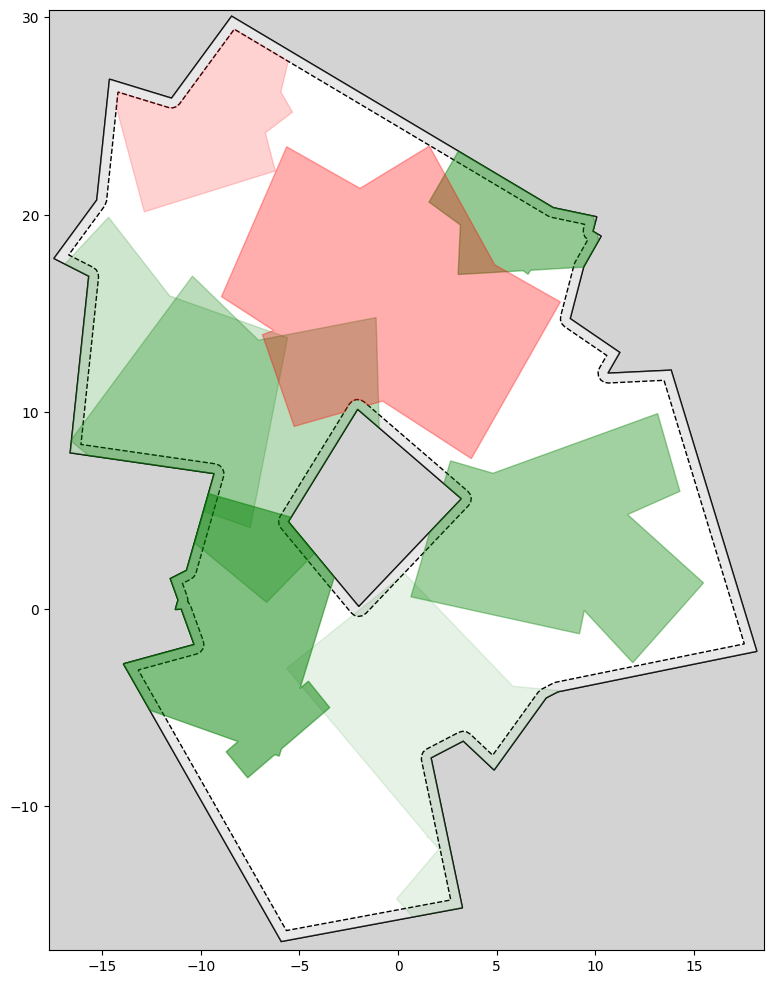

In [3]:
pi = RandomPolygonInstanceGenerator(
    complexity=7,
    size=20,
    penalties=5,
    multiplier=2,
    turn_costs=10,
    penalty_strength=40,
    multiplier_strength=20,
    tool_radius=tool_radius,
)()
ax = setup_plot()
plot_polygon_instance(ax, pi)
plt.show()

In [4]:
InstanceStatistics(pi).as_json()

{'area': 822.3260366510178,
 'perimeter': 145.75148580796653,
 'perimeter_vertices': 72,
 'holes': {'min': 58.06598984955754,
  'max': 58.06598984955754,
  'mean': 58.06598984955754,
  'std': 0.0,
  'sum': 58.06598984955754,
  'n': 1},
 'relative_hole_area': 0.06595469756849233,
 'tool_radius': 0.5}

In [5]:
import itertools
import math

<Figure size 640x480 with 0 Axes>

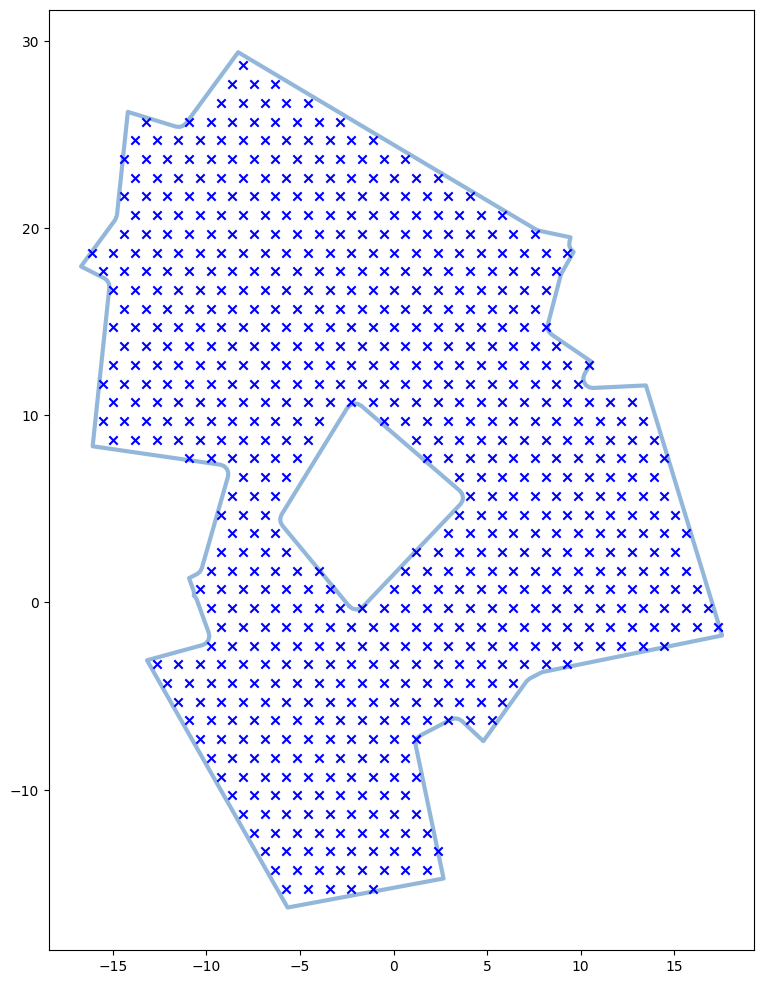

709


In [6]:
from pcpptc.instance_converter.grid.basic_grids import hexagonal_grid

pa = PolygonalArea(polygon=pi.feasible_area)
bb = pa.get_bounding_box()
f = 1.0
opt_hex_length = (2 / math.sqrt(3)) * 2 * tool_radius
grid = hexagonal_grid(
    min_x=bb[0][0],
    min_y=bb[0][1],
    max_x=bb[1][0],
    max_y=bb[1][1],
    side_length=f * opt_hex_length,
)
grid_points = [PointVertex(p) for p in pa.filter(grid)]
ax = setup_plot()
plot_environment(ax, pa)
plot_points(ax, grid_points)
plt.show()
print(len(grid_points))

<Figure size 640x480 with 0 Axes>

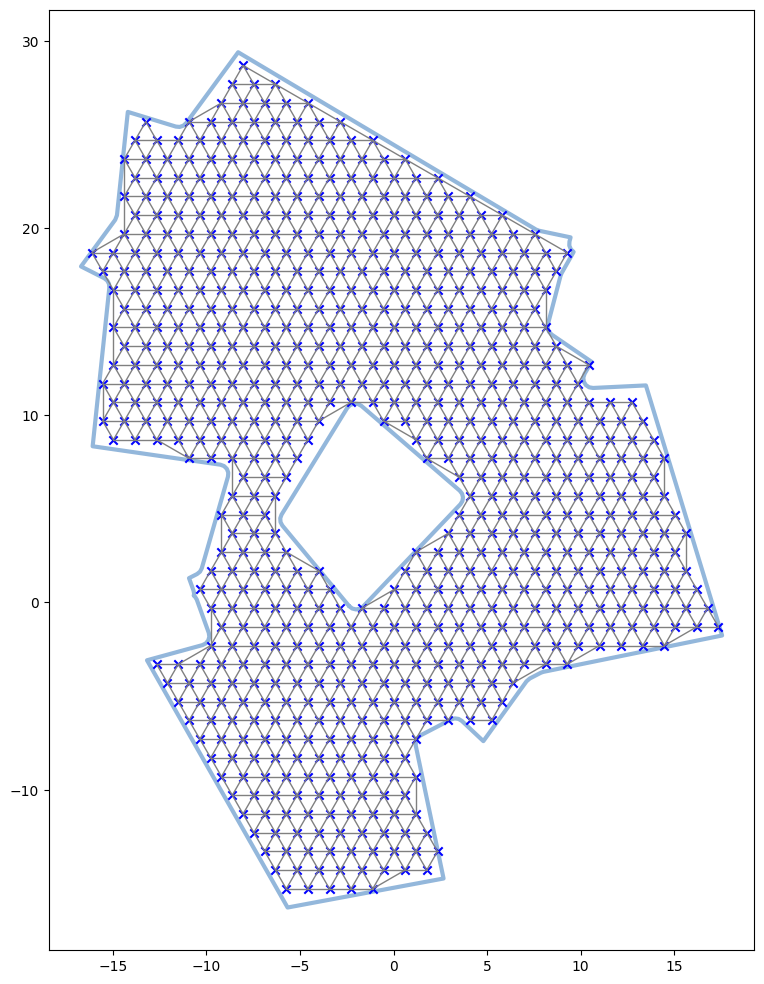

In [7]:
from pcpptc.instance_converter.graph import (
    create_delaunay_graph,
    attach_multiplier_to_graph,
)

G = create_delaunay_graph(grid_points, length_limit=2 * opt_hex_length, polygon=pa)
attach_multiplier_to_graph(G, pi, 0.25 * tool_radius)
ax = setup_plot()
plot_environment(ax, pa)
plot_graph(ax, G)
plt.show()

In [8]:
from pcpptc.instance_converter.graph import (
    get_coverage_necessities_from_polygon_instance,
)
from pcpptc.grid_solver.grid_instance import MultipliedTouringCosts

obj = MultipliedTouringCosts(graph=G, distance_factor=1.0, turn_factor=50.0)
coverage_necessities = get_coverage_necessities_from_polygon_instance(pi, G)

In [9]:
from pcpptc.grid_solver.cycle_cover.fractional_grid_solver import FractionalGridSolver
from pcpptc.grid_solver import PointBasedInstance

instance = PointBasedInstance(G, obj, coverage_necessities)
fractional_solution = FractionalGridSolver()(instance)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16


<Figure size 640x480 with 0 Axes>

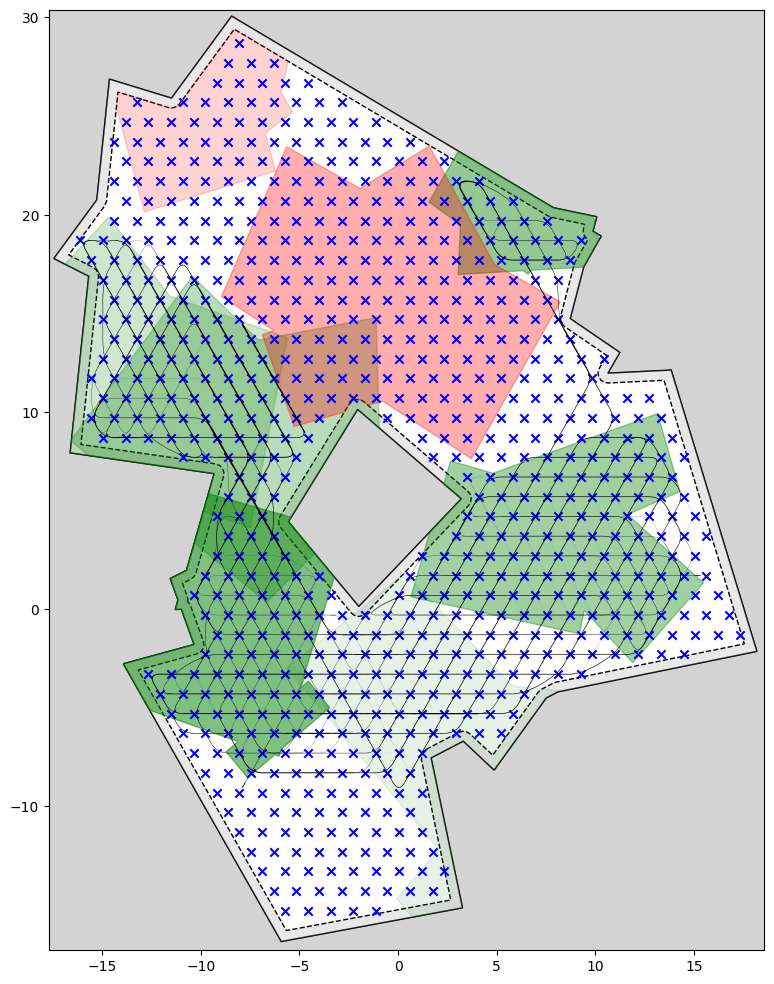

In [10]:
from pcpptc.plot.intermediate import plot_fractional_solution

ax = setup_plot()
ax.set_facecolor("lightgrey")
plot_polygon_instance(ax, pi)
plot_points(ax, grid_points)
plot_fractional_solution(ax, fractional_solution[0])
plt.show()

Using static atomic strip selection strategy.


<Figure size 640x480 with 0 Axes>

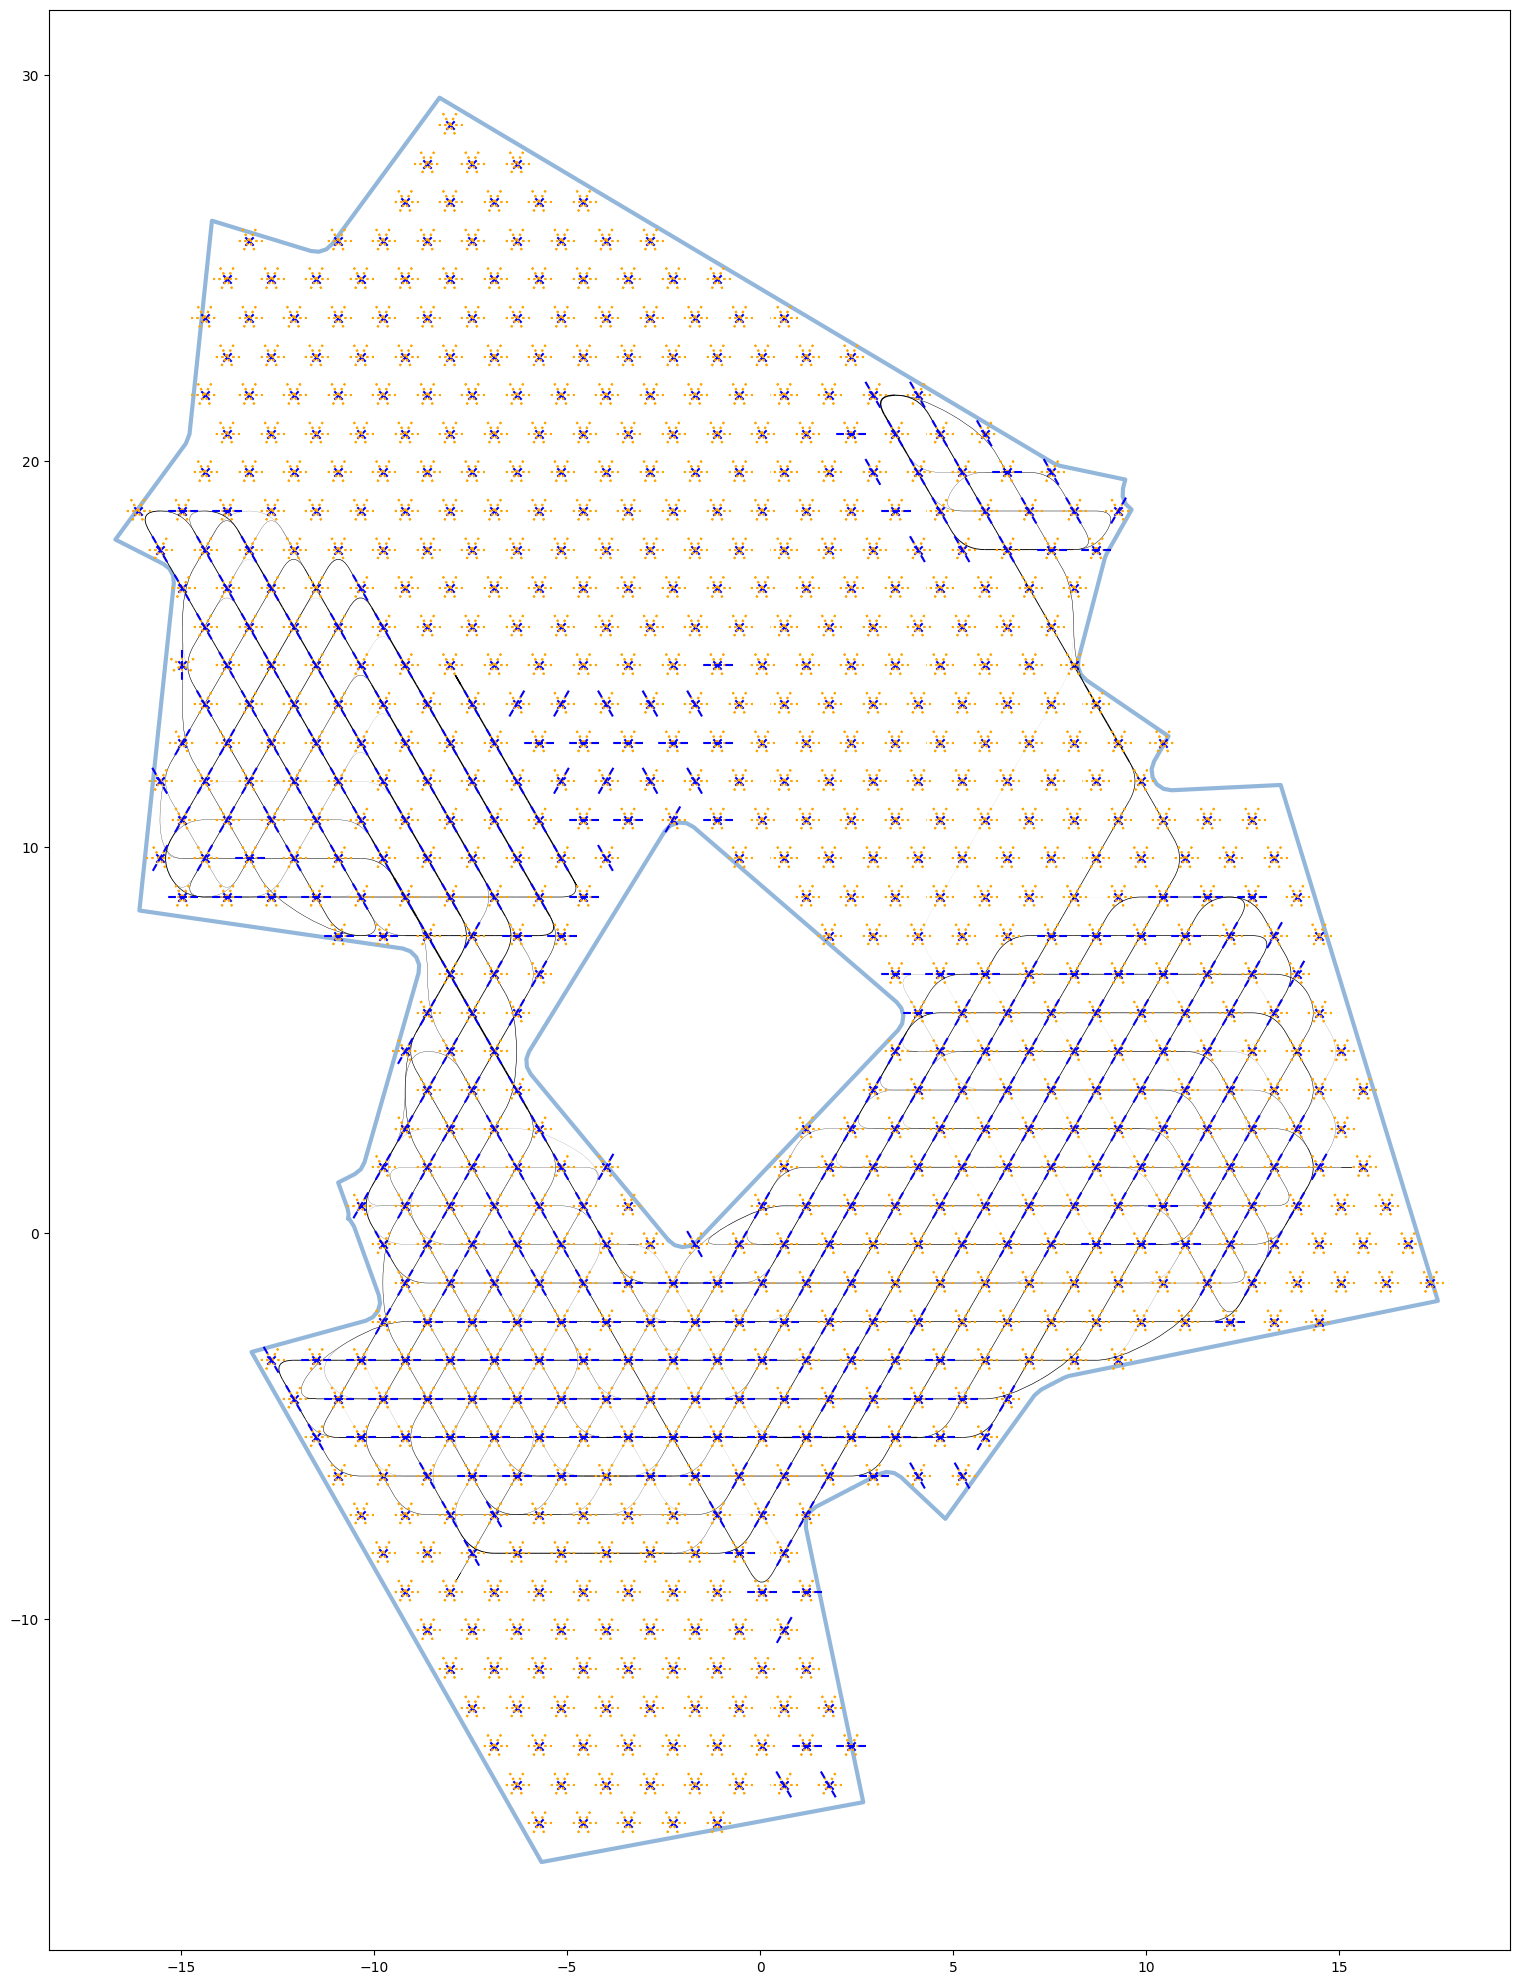

In [11]:
from pcpptc.plot.atomic_strip_orientation import plot_atomic_strips
from pcpptc.grid_solver.cycle_cover.atomic_strip_orientation import (
    EquiangularRepetitionAtomicStrips,
)

fb = EquiangularRepetitionAtomicStrips(
    number_of_different_orientations=3, reptition_of_each_orientation=2
)
atomic_strips = fb(instance, fractional_solution[0])

ax = setup_plot(figsize=(20, 20))
plot_environment(ax, pa)
plot_points(ax, G.nodes)
plot_fractional_solution(ax, fractional_solution[0])
plot_atomic_strips(ax, atomic_strips, tool_radius)
plt.show()

# 07. Matching on Strip Cover

In [12]:
from pcpptc.grid_solver.cycle_cover.atomic_strip_matcher import (
    AtomicStripMatching,
    TransitionCostCalculator,
)

asm = AtomicStripMatching(G, TransitionCostCalculator(instance.touring_costs))

for p in G.nodes:
    for o in atomic_strips[p]:
        s = asm.create_atomic_strip(p, o.orientation)
        if o.is_skippable():
            asm.add_skip_penalty(s, o.penalty)
edges = asm.solve()

Solve matching on 292686 edges.


<Figure size 640x480 with 0 Axes>

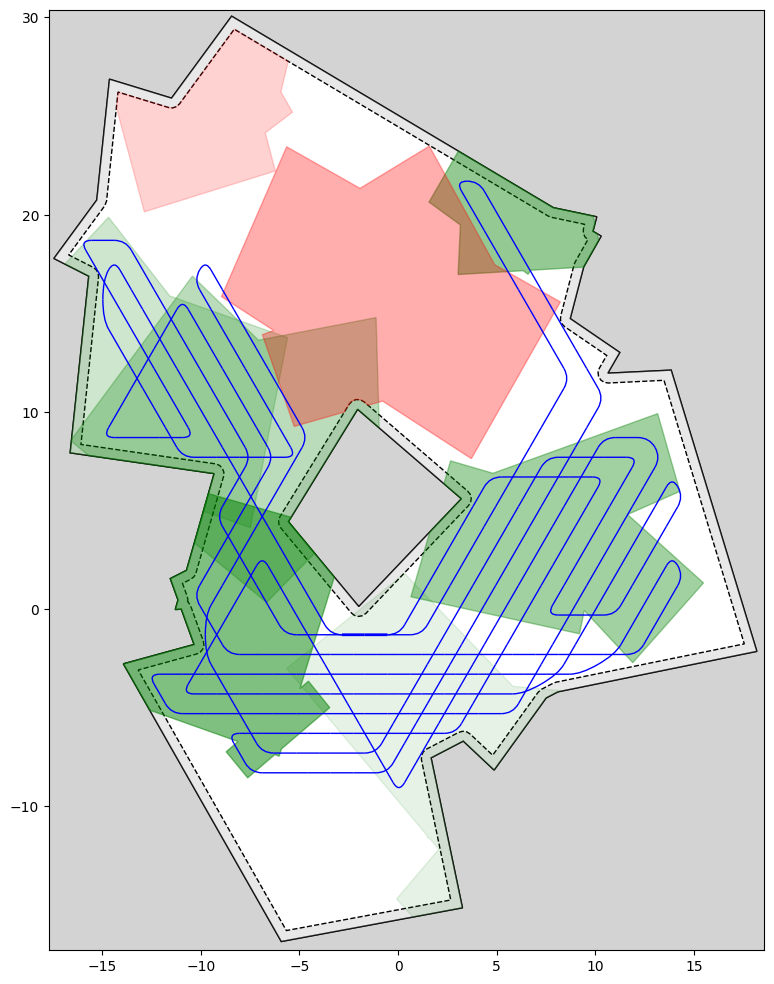

In [13]:
from pcpptc.plot.atomic_strip_matching import plot_atomic_strip_matching

ax = setup_plot()
ax.set_facecolor("lightgrey")
plot_polygon_instance(ax, pi)
plot_atomic_strip_matching(ax, asm, color="blue")
plt.show()

In [14]:
from pcpptc.grid_solver.grid_solution import is_feasible_cycle_cover

fractional_solution = asm.to_solution()
is_feasible_cycle_cover(instance, fractional_solution, verbose=True)

True

In [15]:
from pcpptc.grid_solver.grid_solution import create_cycle_solution

cc = create_cycle_solution(instance.graph, fractional_solution)
print(len(cc))

1


Solution is already connected! :)


<Figure size 640x480 with 0 Axes>

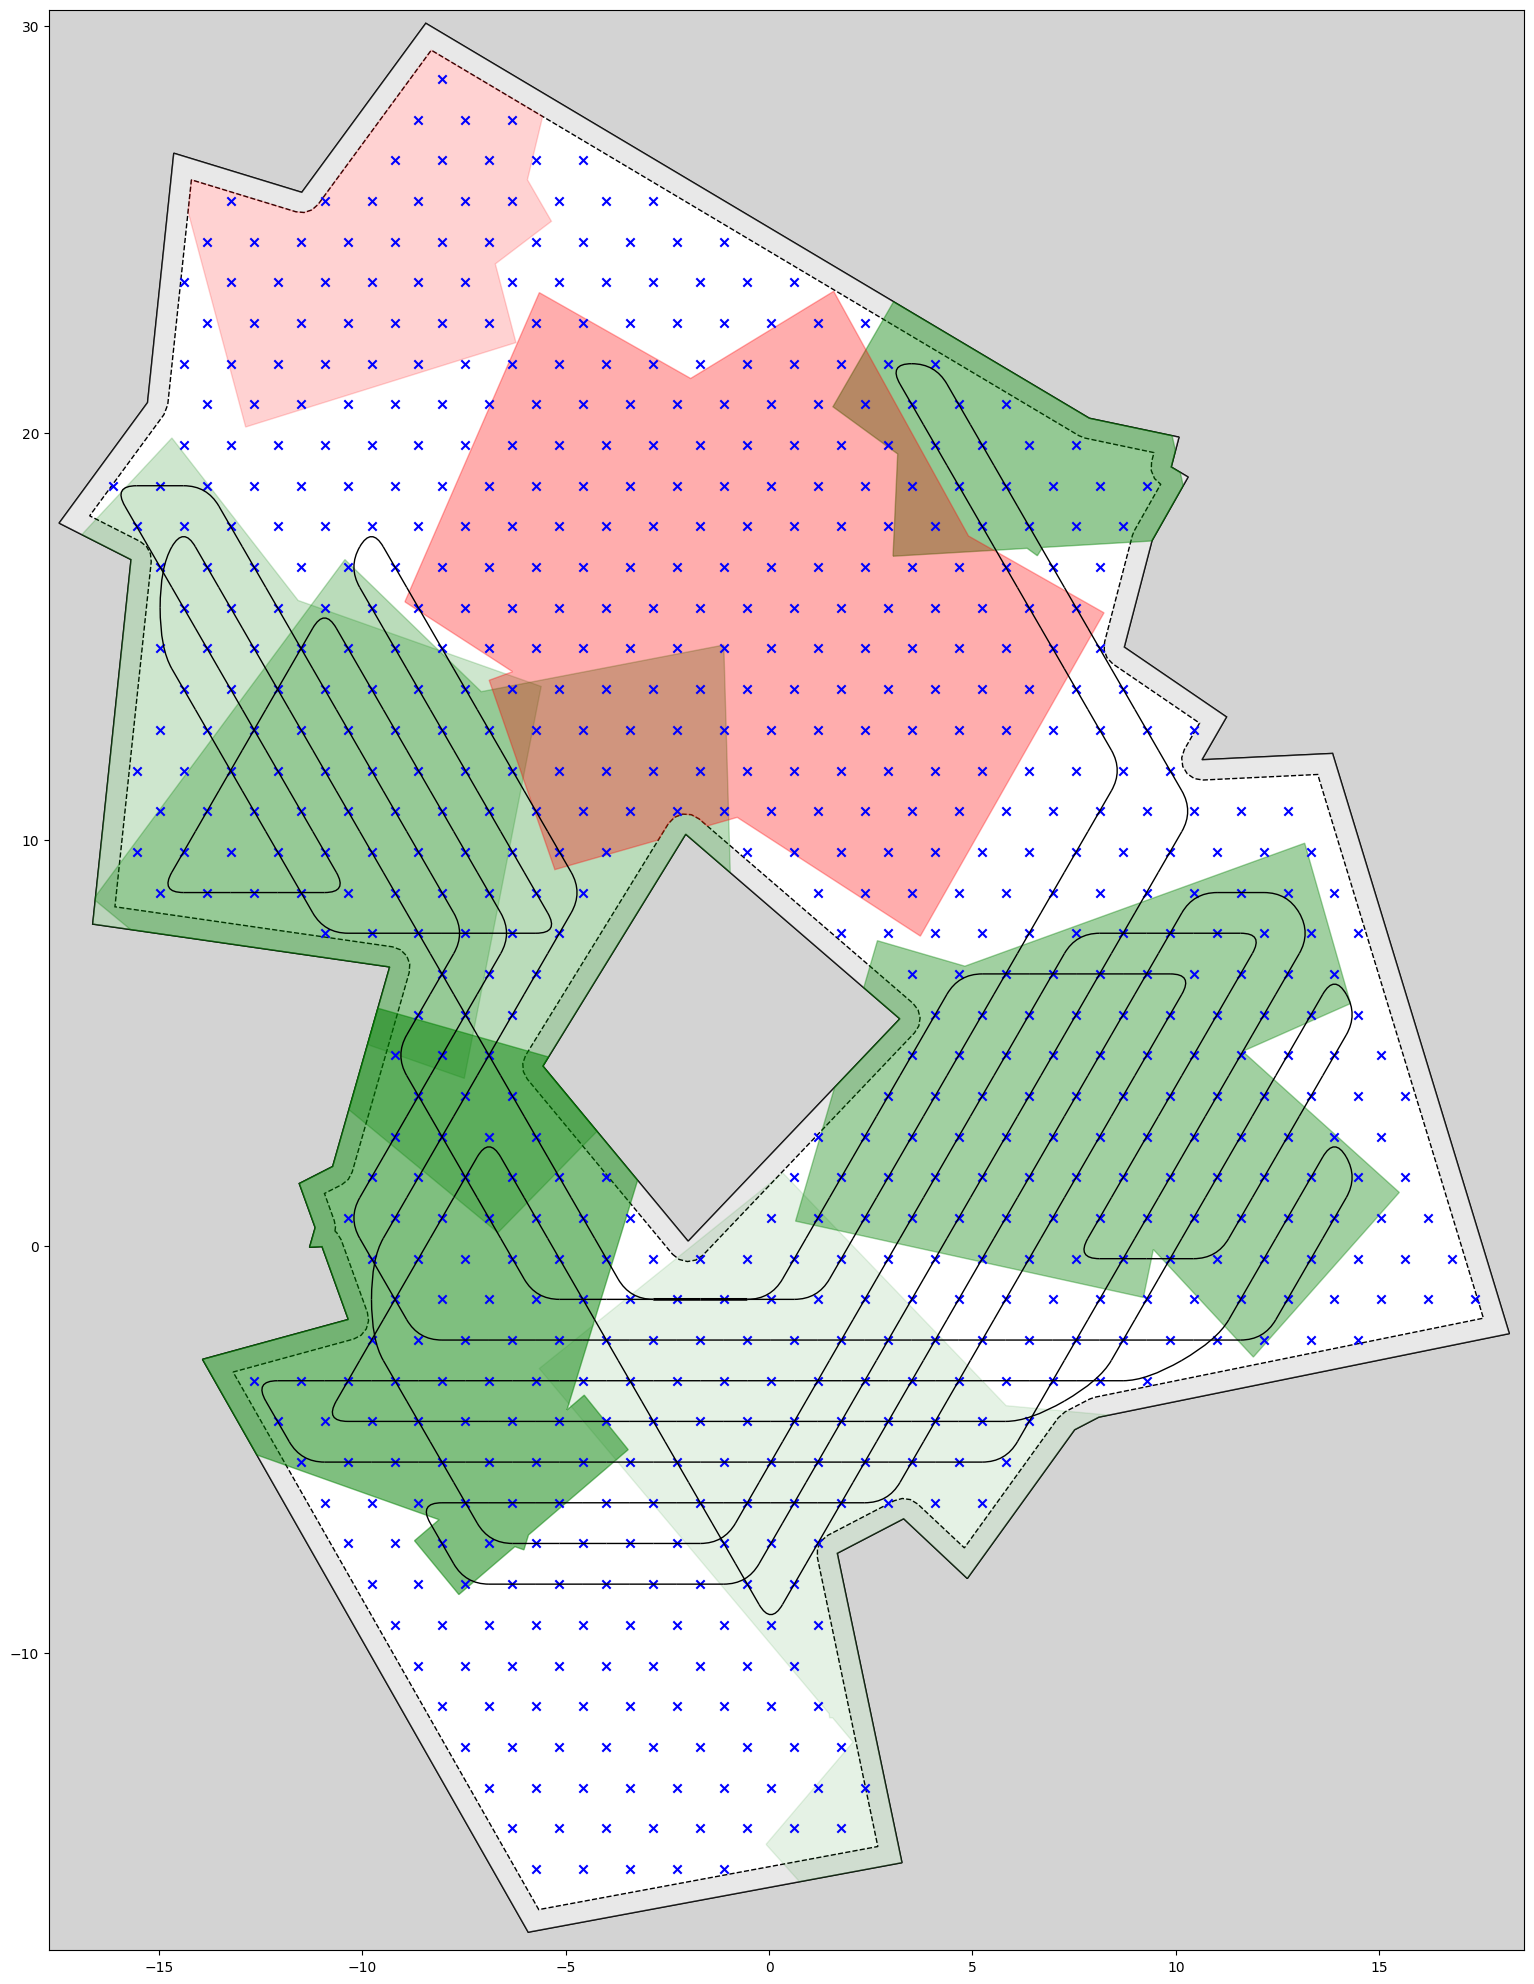

True

In [16]:
tour = connect_cycles_via_pcst(instance, cc)
f = tour.to_fractional_solution()
ax = setup_plot(figsize=(20, 20))
ax.set_facecolor("lightgrey")
plot_polygon_instance(ax, pi)
plot_points(ax, grid_points)
plot_fractional_solution(ax, f)
plt.show()
is_feasible_cycle_cover(instance, f)

<Figure size 640x480 with 0 Axes>

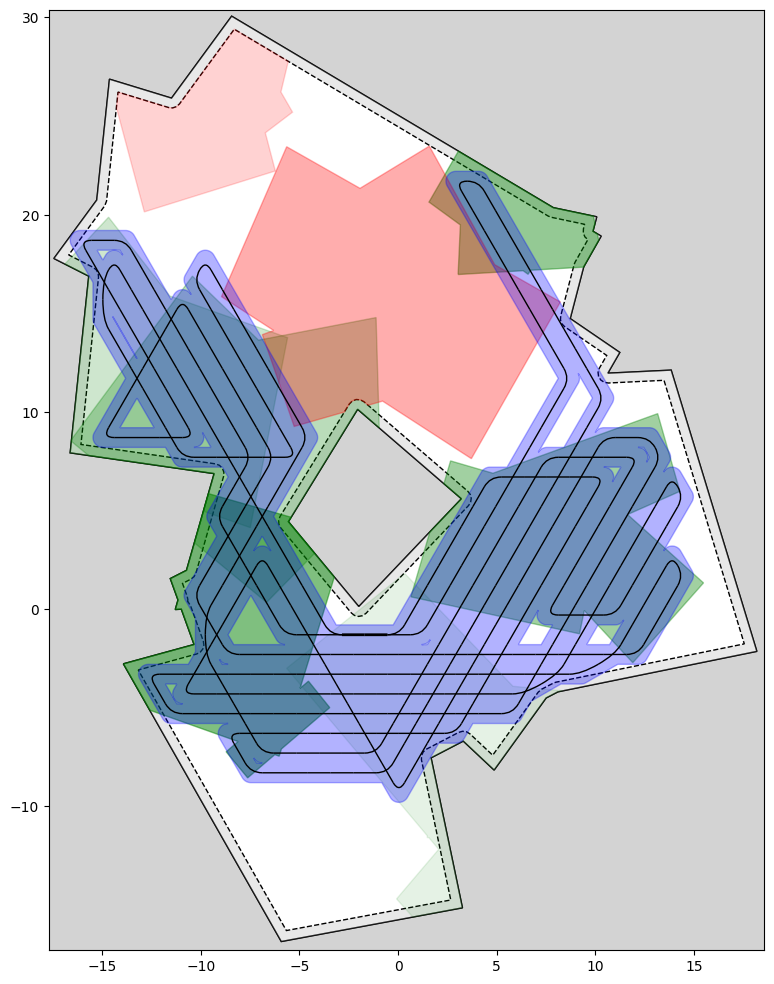

In [17]:
from pcpptc.grid_solver.grid_solution.coverage_analysis import plot_tour_coverage

ax = setup_plot()
ax.set_facecolor("lightgrey")
plot_polygon_instance(ax, pi)
plot_tour_coverage(ax, tour, tool_radius)
plot_fractional_solution(ax, tour.to_fractional_solution())
plt.show()